In [3]:
!pip install opendatasets
import opendatasets

# opendatasets.download("https://www.kaggle.com/datasets/moltean/fruits")  ## OLD DATASET!
opendatasets.download("https://www.kaggle.com/datasets/muhriddinmuxiddinov/fruits-and-vegetables-dataset")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rafalkos
Your Kaggle Key: ··········


100%|██████████| 870M/870M [00:10<00:00, 87.7MB/s]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import keras.utils as image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model, load_model
from keras.optimizers import Adam
import tensorflow as tf
import cv2
from pathlib import Path
import os
import random
import shutil
import math


## OLD DATASET
# # Folders used for training / testing
# fruits_and_vegetables = ["Apple Red 1", "Avocado", "Banana", "Blueberry", 
#                          "Carambula", "Cauliflower", "Cocos", "Corn", 
#                          "Eggplant", "Lemon", "Limes", "Lychee", "Onion Red", 
#                          "Orange", "Pear", "Pepper Red", "Pineapple", 
#                          "Raspberry", "Strawberry", "Watermelon"]

# # Path to dataset
# test_data_dir = Path(os.getcwd()) / "fruits" / "fruits-360_dataset" / "fruits-360" / "Test"
# train_data_dir = Path(os.getcwd()) / "fruits" / "fruits-360_dataset" / "fruits-360" / "Training"

# # Define size of input images
# img_width, img_height = 100, 100


## NEW DATASET
# Initial preparation: move class folders to one folder

dataset_main_path = Path("/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset(12000)")
for el in ["Fruits", "Vegetables"]:
    if os.path.exists(dataset_main_path / el):
        for dir in os.listdir(dataset_main_path / el):
            shutil.copytree(dataset_main_path / el / dir, dataset_main_path / dir)
        shutil.rmtree(dataset_main_path / el)


def split_dataset(path_to_data, ratio=0.75):
    """
    Splits dataset into train and test data with given ratio, creates two folders: 
        Test
        Train
    """
    test_path = Path("Dataset//Test")
    train_path = Path("Dataset//Train")
    if os.path.exists(test_path):
        shutil.rmtree(test_path)
    
    if os.path.exists(train_path):
        shutil.rmtree(train_path)
    
    os.makedirs(train_path)
    os.makedirs(test_path)

    for cls in os.listdir(path_to_data):
        files_list = os.listdir(path_to_data / cls)
        train_files = set(random.sample(files_list, math.floor(len(files_list) * 0.75)))
        test_files = set(files_list) - train_files

        if os.path.exists(test_path / cls):
            shutil.rmtree(test_path / cls)
        if os.path.exists(train_path / cls):
            shutil.rmtree(train_path / cls)
        
        os.makedirs(train_path / cls)
        os.makedirs(test_path / cls)

        for file in train_files:
            shutil.copy(path_to_data / cls / file, train_path / cls / file)
        for file in test_files:
            shutil.copy(path_to_data / cls / file, test_path / cls / file)
        
split_dataset(dataset_main_path)

# Path to dataset
test_data_dir = Path("Dataset//Test")
train_data_dir = Path("Dataset//Train")

# Define size of input images
img_width, img_height = 150, 150

# Define number of classes
if len(os.listdir(test_data_dir)) == len(os.listdir(train_data_dir)):
    class_labels = os.listdir(test_data_dir)
    num_classes = len(class_labels)
else:
    raise Exception("Test folder and train folder has different number of classes.")

In [5]:
# PARAMETERS
num_epochs = 10
save_to_file = True
# MODIFY NET ARCHITECTURE IN CODE BELOW
# MODIFY FROZEN LAYERS IN CODE BELOW

# Create training set generator using augumentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Create test set generator without augumentation, only normalizing
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate train data from dataset
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    classes=class_labels,
    class_mode='categorical')

# Generate test data from dataset
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    classes=class_labels,
    class_mode='categorical')

# Load pretrained (on dataset "imagenet") VGG16 model excluding last layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add classification layers
# MODIFY ARCHITECTURE IF NEEDED
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create new model based on VGG16 and our classification layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze weights of convolutional layers of VGG16 model (only train classiication)
# MODIFY FROZEN LAYERS BY SLICING base_model.layers, eg. base_model.layers[:-3]
for layer in base_model.layers[:-3]:
    layer.trainable = False

# Compile prepared model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=num_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32)

# Save model to file
if save_to_file:
    model.save("model_vgg16_freeze_3.h5")

Found 8984 images belonging to 20 classes.
Found 3002 images belonging to 20 classes.
58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/10
 33/280 [==>...........................] - ETA: 1:25 - loss: 3.1058 - accuracy: 0.0852

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


280/280 [==============================] - 132s 418ms/step - loss: 2.1561 - accuracy: 0.3496 - val_loss: 0.9201 - val_accuracy: 0.7403
Epoch 2/10
280/280 [==============================] - 114s 406ms/step - loss: 1.0965 - accuracy: 0.6621 - val_loss: 0.5806 - val_accuracy: 0.8209
Epoch 3/10
280/280 [==============================] - 113s 405ms/step - loss: 0.7781 - accuracy: 0.7598 - val_loss: 0.4728 - val_accuracy: 0.8552
Epoch 4/10
280/280 [==============================] - 114s 408ms/step - loss: 0.5768 - accuracy: 0.8236 - val_loss: 0.4033 - val_accuracy: 0.8700
Epoch 5/10
280/280 [==============================] - 114s 407ms/step - loss: 0.4567 - accuracy: 0.8609 - val_loss: 0.3552 - val_accuracy: 0.8935
Epoch 6/10
280/280 [==============================] - 111s 395ms/step - loss: 0.3996 - accuracy: 0.8824 - val_loss: 0.3806 - val_accuracy: 0.8888
Epoch 7/10
280/280 [==============================] - 113s 405ms/step - loss: 0.3232 - accuracy: 0.9034 - val_loss: 0.3001 - val_accura

In [6]:
# Load model from file if you trained and saved before
model = load_model("model_vgg16_freeze_3.h5")
from google.colab import files
files.download("model_vgg16_freeze_3.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [12]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        
        raise ValueError("No 4D layers found!")

    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(inputs=[self.model.inputs],
                          outputs=[self.model.get_layer(self.layerName).output, self.model.output])
        
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        
        grads = tape.gradient(loss, convOutputs)
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1-alpha, 0)

        return (heatmap, output)


def predict_photo(photo, n=3):
    """
    Predicts label of given photo. If file_name is None,
    random photo is chosen from folder_name directory

    Returns list of tuples of top n guesses.
    """
    prediction = np.array(model(photo, training=False))
    idxs = prediction.argsort()[0][::-1][:n]
    preds = [(class_labels[idx], prediction[0][idx]) for idx in idxs]
    return preds


def choose_random_file(folder_name):
    """
    Chooses random file from given folder and returns its name.
    """
    return random.choice(os.listdir(test_data_dir / folder_name))


def plot_heatmap(folders=None, files=None):
    """ 
    Plots 6 predictions with heatmap from given folders, 
    if folders are None, chooses them randomly
    if files are not None it should contain paths to custom photos.
    """
    if folders is None:
        pthlist = random.sample(class_labels, 6)
    else:
        pthlist = folders

    if files is not None:
        pthlist = files
    
    fig, axs = plt.subplots(2, 3)
    fig.set_size_inches(14, 12)
    for i, pth in enumerate(pthlist):
        if files is None:
            rand_file = choose_random_file(pth)
            img_path = test_data_dir / pth / rand_file
            class_idx = class_labels.index(pth)
        else:
            img_path = pth[0]
            class_idx = class_labels.index(pth[1])
        print(pth[1])
        print(class_idx)
        img_orig = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
        img_orig = cv2.resize(img_orig, (img_width, img_height))
        
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = img / 255.0

        preds = predict_photo(img)
        gradcam = GradCAM(model, class_idx)
        heatmap = gradcam.compute_heatmap(img)
        heatmap = cv2.resize(heatmap, (img_width, img_height))
        (heatmap, output) = gradcam.overlay_heatmap(heatmap, img_orig, alpha=0.5)

        axs[i//3, i%3].imshow(output)
        axs[i//3, i%3].set_title(f"Class: {class_labels[class_idx]}\n "
                                 f"{preds[0][0]}: {np.round(preds[0][1]*100, 2)}%\n"
                                 f"{preds[1][0]}: {np.round(preds[1][1]*100, 2)}%\n"
                                 f"{preds[2][0]}: {np.round(preds[2][1]*100, 2)}%")

r
19
r
12
o
7
o
16
o
0
o
11


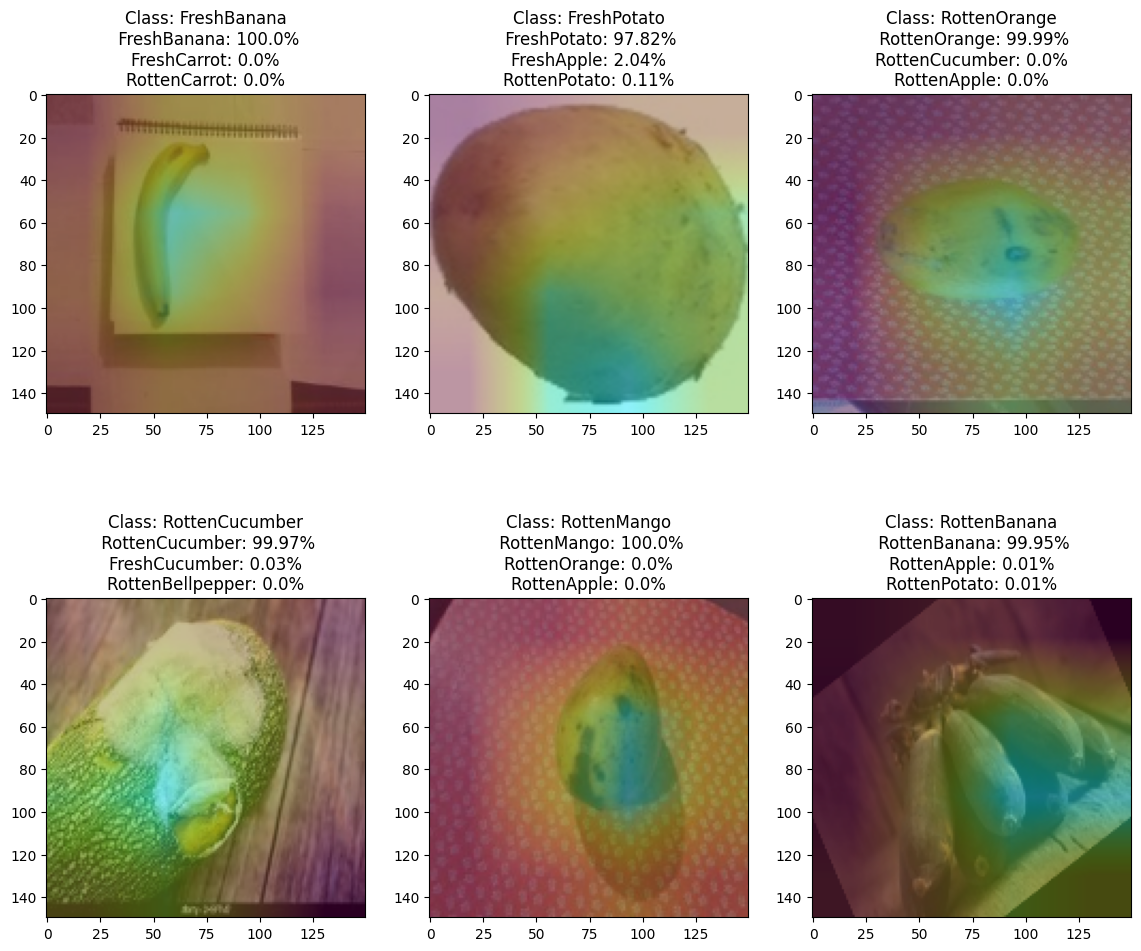

In [13]:
#plot_heatmap(folders=["Pear", "Watermelon", "Banana", "Raspberry", "Banana"])
#plot_heatmap(files=[('pear.jpg', "Pear"), ('watermelon.jpg', "Watermelon"), ('banana.jpg', "Banana")])
plot_heatmap()